In [1]:
# import pakages
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# necessary variables
# 이미지 사이즈 변수
IMAGE_SIZE = 224

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/jellyfish/Train_Test_Valid/Train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/jellyfish/Train_Test_Valid/valid/*/*'
TEST_PATH = ROOT_PATH + '/jellyfish/Train_Test_Valid/test/*/*'

BATCH_SIZE = 32
EPOCHS = 30      

In [3]:
import glob

#디렉토리별 데이터 개수 확인
train_filenames = glob.glob(TRAIN_PATH)
test_filenames = glob.glob(TEST_PATH)
val_filenames = glob.glob(VAL_PATH)

train_count = len(train_filenames)
test_count = len(test_filenames)
val_count = len(val_filenames)

print("train:", train_count)
print("test:", test_count)
print("validation:", val_count)

train: 900
test: 40
validation: 39


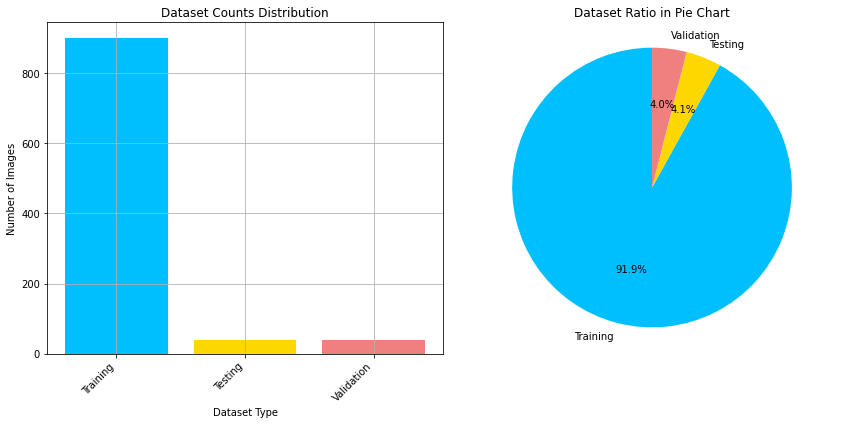

In [4]:
# visualize dataset
import matplotlib.pyplot as plt

def visualize_dataset_counts(labels, counts, colors):
    # Create the charts
    plt.figure(figsize=(12, 6))  

    # Bar Chart
    plt.subplot(121)
    plt.bar(labels, counts, color=colors)
    plt.xlabel("Dataset Type")
    plt.ylabel("Number of Images")
    plt.title("Dataset Counts Distribution")
    plt.grid(True)  # Add gridlines for visual reference
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility

    # Create the pie chart
    plt.subplot(122)  # Position the pie chart in the second subplot
    plt.pie(counts, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
    plt.title("Dataset Ratio in Pie Chart")
    plt.axis("equal")  # Ensure a circular pie chart

    # Adjust layout for better visualization
    plt.tight_layout()  # Prevent overlapping elements

    # Display the combined chart
    plt.show()


labels = ["Training", "Testing", "Validation"]
counts = [train_count, test_count, val_count]
colors = ["deepskyblue", "gold", "lightcoral"]

visualize_dataset_counts(labels, counts, colors)


# train / validation dataset 다시 나누기

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)

train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

train_count = len(train_filenames)
val_count = len(val_filenames)

print("train:", train_count)
print("validation:", val_count)

train: 751
validation: 188


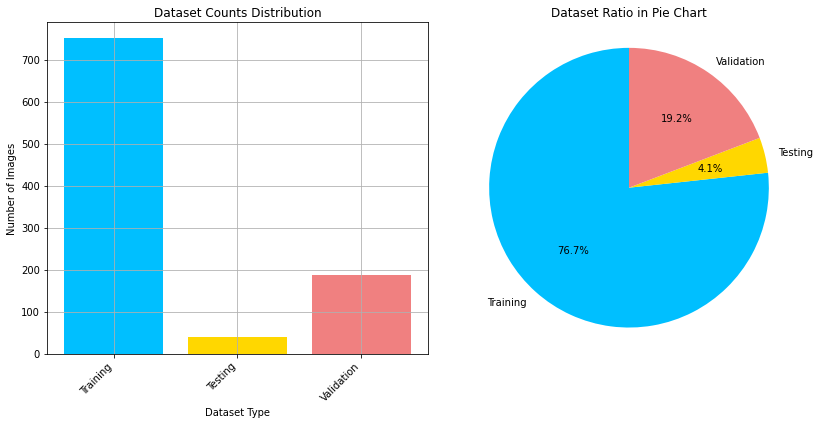

In [6]:
# 나눠진 데이터 다시 시각화
labels = ["Training", "Testing", "Validation"]
counts = [train_count, test_count, val_count]
colors = ["deepskyblue", "gold", "lightcoral"]

visualize_dataset_counts(labels, counts, colors)

# 미니배치 사용

In [7]:
# tf.data instance 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 751
Validating images count: 188


# 데이터 전처리

In [9]:
# 레이블 딕셔너리 생성
label_dict = {
    'Moon_jellyfish': 0,
    'barrel_jellyfish': 1,
    'blue_jellyfish': 2,
    'compass_jellyfish': 3,
    'lions_mane_jellyfish': 4,
    'mauve_stinger_jellyfish': 5
}

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    if parts[-2] == "barrel_jellyfish":
        return 0   # barrel_jellyfish이면 라벨 0

    elif parts[-2] == "blue_jellyfish":
        return 1   # blue_jellyfish이면 라벨 1

    elif parts[-2] == "compass_jellyfish":
        return 2   # compass_jellyfish이면 라벨 2

    elif parts[-2] == "lions_mane_jellyfish":
        return 3   # lions_mane_jellyfish이면 라벨 3

    elif parts[-2] == "mauve_stinger_jellyfish":
        return 4   # mauve_stinger_jellyfish이면 라벨 4

    else :
        return 5  # Moon_jellyfish이면 라벨 5

In [11]:
# 이미지 형식 변경 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # 이미지 사이즈를 IMAGE_SIZE로 수정 : 224x224
    return img

# 이미지 파일 경로로 이미지와 레이블 읽어오는 함수
def process_path(file_path):
    label = get_label(file_path) # 레이블 뽑기
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
# train, validation dataset 만들기
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE 변수 이용
## AUTOTUNE : 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
# 이미지 리사이즈 결과, 레이블 확인
for image, label in train_ds.take(1): # 하나의 데이터만 가져온다
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  0


In [40]:
train_ds

<ParallelMapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

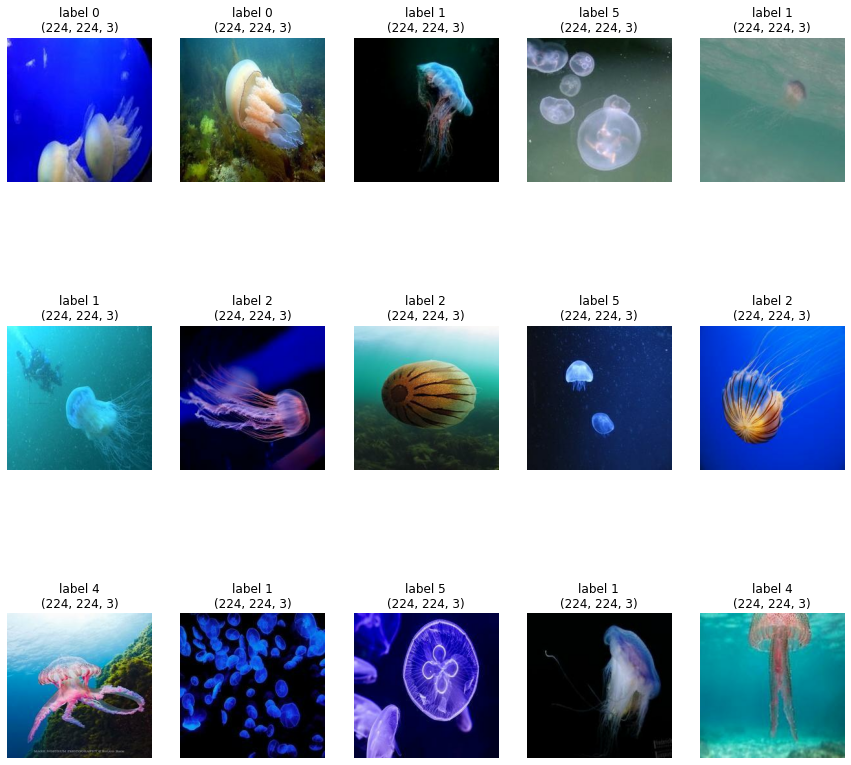

In [25]:
import matplotlib.pyplot as plt
import math

def show_dataset_samples(dataset, num_samples=15):
    plt.figure(figsize=(15, 15))
    
    for idx, (img, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(3, 5, idx + 1)
        plt.imshow(img)
        plt.title(f'label {label}\n{img.shape}')
        plt.axis('off')

# Usage example with your training dataset
show_dataset_samples(train_ds)
plt.show()  # Display the figure


In [15]:
# test dataset 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print("test dataset:", TEST_IMAGE_COUNT)

test dataset: 40


# data batches

In [33]:
# augmentation function
def augment(img, label):
    # Randomly flip left or right
    img = tf.image.random_flip_left_right(img)
    
    # add 3 pixels of padding
    img = tf.image.resize_with_crop_or_pad(img, IMAGE_SIZE+3, IMAGE_SIZE+3)
    # random crop back to the original size
    img = tf.image.random_crop(img, size=[IMAGE_SIZE,IMAGE_SIZE,3])
    
    return img,label

In [34]:
# 배치사이즈, 학습데이터 적절히 섞을 shuffle_buffer_size
SHUFFLE_BUFFER_SIZE = 1000

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # data augmentation including normalization
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)  # 32
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

train_batches = prepare_for_training(train_ds)
val_batches = prepare_for_training(val_ds)
test_batches = test_ds.batch(BATCH_SIZE)

In [35]:
# train batch 중 하나 확인
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32]))

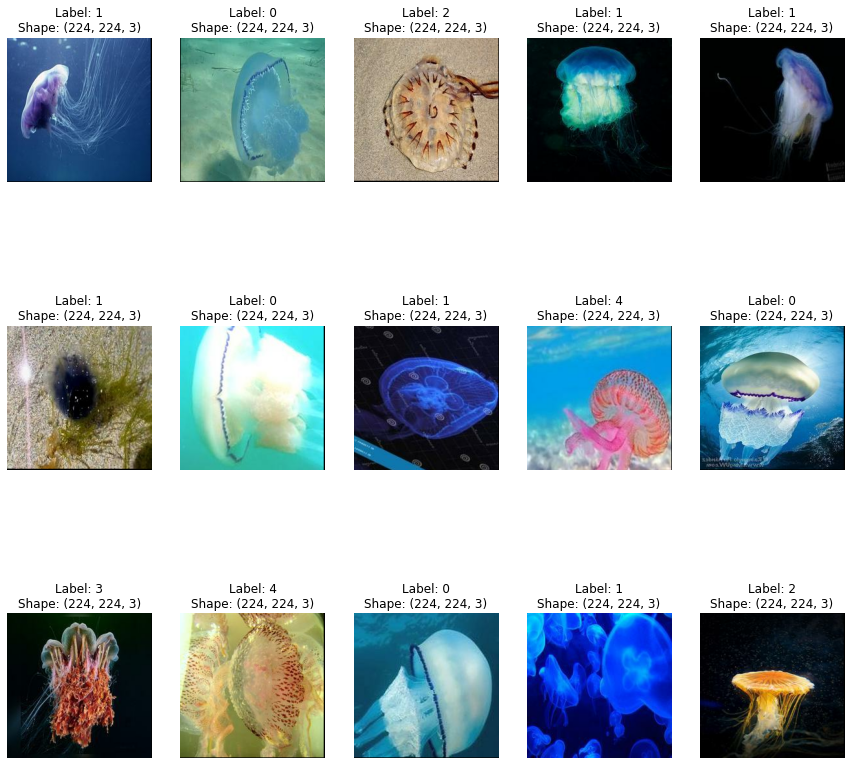

In [51]:
def show_batch(image_batch, label_batch, class_names=None):
    plt.figure(figsize=(15, 15))
    for i in range(min(len(image_batch), 15)):
        plt.subplot(3, 5, i + 1)
        plt.imshow(image_batch[i])
        if class_names is not None:
            plt.title(f'{class_names[label_batch[i]]}\n{image_batch[i].shape}')
        else:
            plt.title(f'Label: {label_batch[i]}\nShape: {image_batch[i].shape}')   
        plt.axis('off')
    plt.show()

# show the batch
show_batch(image_batch, label_batch)
plt.show()

In [56]:
# Calculate the number of batches
num_batches = tf.data.experimental.cardinality(train_batches).numpy() // BATCH_SIZE

print(f'Total batches: {num_batches}')

Total batches: -1


# 모델1 - CNN

In [58]:
# convolution block
'''
- convolution 2번 
    - activation : relu
    - same padding
    - kernel size : 3x3
- batch normalization
- max pooling 
    - pool size : 2x2
'''
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [59]:
# dense block
'''
activation : relu
batch normalization
dropout
'''
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [68]:
# build model = convolution block + dense block 합치기
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    return model

In [63]:
# gpu로 모델 빌드, 컴파일

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint
check_point_cb = ModelCheckpoint('basic_cnn.keras')
# early stopping
early_stopping_cb = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = ['accuracy']
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

In [64]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
sequential (Sequential)      (None, 56, 56, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 14, 14, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)      

In [67]:
# gpu로 모델학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_batches,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_batches,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[check_point_cb, early_stopping_cb]
    )

Epoch 1/30
23/23 [==============================] - 21s 213ms/step - loss: 2.3865 - accuracy: 0.1984 - val_loss: 1.7926 - val_accuracy: 0.1875
Epoch 2/30
23/23 [==============================] - 4s 179ms/step - loss: 2.0170 - accuracy: 0.2582 - val_loss: 1.8093 - val_accuracy: 0.1500
Epoch 3/30
23/23 [==============================] - 4s 181ms/step - loss: 1.8772 - accuracy: 0.3111 - val_loss: 1.8398 - val_accuracy: 0.1250
Epoch 4/30
23/23 [==============================] - 4s 182ms/step - loss: 1.8481 - accuracy: 0.3193 - val_loss: 1.8319 - val_accuracy: 0.1937


In [69]:
# 모델 저장
model.save('cnn_model')

# history 저장
import os
import pickle

# Specify the directory path
directory_path = '/aiffel/aiffel/DLthon'

# Ensure the directory exists, create it if not
os.makedirs(directory_path, exist_ok=True)

# Full file path
file_path = os.path.join(directory_path, 'cnn_train_history_dict.pkl')

# Assuming history.history is defined somewhere in your code
with open(file_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
# # history 불러오기 테스트
# history = pickle.load(open('/trainHistoryDict', "rb"))
# print(history)

INFO:tensorflow:Assets written to: cnn_model/assets


# modified cnn

In [70]:
# build model = convolution block + dense block 합치기
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        dense_block(32, 0.5),
        
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    return model

In [71]:
# checkpoint
check_point_cb = ModelCheckpoint('shallow_cnn.keras')
# early stopping
early_stopping_cb = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = ['accuracy']
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

In [72]:
# gpu로 모델학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_batches,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_batches,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[check_point_cb, early_stopping_cb]
    )

Epoch 1/30
23/23 [==============================] - 5s 154ms/step - loss: 2.2982 - accuracy: 0.2568 - val_loss: 2.2845 - val_accuracy: 0.1750
Epoch 2/30
23/23 [==============================] - 3s 145ms/step - loss: 1.9097 - accuracy: 0.3016 - val_loss: 2.3939 - val_accuracy: 0.1562
Epoch 3/30
23/23 [==============================] - 3s 144ms/step - loss: 1.7681 - accuracy: 0.3125 - val_loss: 2.1944 - val_accuracy: 0.1625
Epoch 4/30
23/23 [==============================] - 3s 145ms/step - loss: 1.6353 - accuracy: 0.3451 - val_loss: 1.9954 - val_accuracy: 0.1750
Epoch 5/30
23/23 [==============================] - 3s 144ms/step - loss: 1.4484 - accuracy: 0.4470 - val_loss: 1.8152 - val_accuracy: 0.1750
Epoch 6/30
23/23 [==============================] - 3s 149ms/step - loss: 1.2840 - accuracy: 0.5095 - val_loss: 1.9137 - val_accuracy: 0.1312
Epoch 7/30
23/23 [==============================] - 3s 146ms/step - loss: 1.1999 - accuracy: 0.5353 - val_loss: 1.7721 - val_accuracy: 0.1688
Epoch 

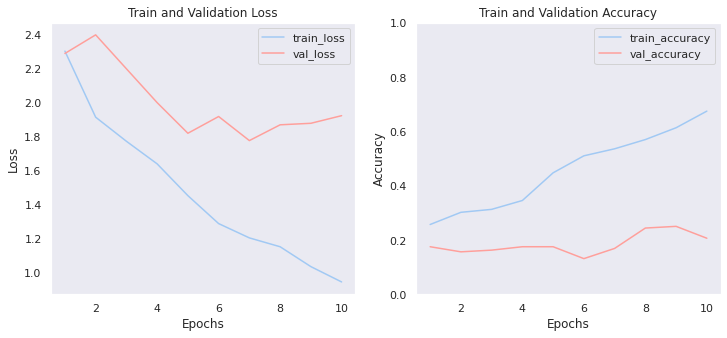

In [73]:
# 학습결과 시각화
import seaborn as sns
sns.set_theme(style='darkgrid', palette='pastel')

# history 1개 보여주는 그래프
def show_history(history):
    history_dict = history.history
    
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(accuracy) + 1)
    
    fig = plt.figure(figsize=(12, 5))
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, 'b-', label='train_loss')
    ax1.plot(epochs, val_loss, 'r-', label='val_loss')
    ax1.set_title('Train and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
    ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')

    ax2.set_ylim(0, 1)
    ax2.set_title('Train and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()
    
    plt.show()

show_history(history)

- 이 그래프 어디서 많이 봤다...
- 과대적합?!

In [74]:
# 모델 저장
model.save('shallow_cnn_model')

# history 저장
# Specify the directory path
directory_path = '/aiffel/aiffel/DLthon'

# Full file path
file_path = os.path.join(directory_path, 'shallow_cnn_train_history_dict.pkl')

# Assuming history.history is defined somewhere in your code
with open(file_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
# # history 불러오기 테스트
# history = pickle.load(open('/trainHistoryDict', "rb"))
# print(history)

INFO:tensorflow:Assets written to: shallow_cnn_model/assets


In [75]:
del model
del history

# Shallow ResNet(not ResNet-18)

In [76]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SeparableConv2D, MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow.keras.callbacks import EarlyStopping

In [82]:
'''
n_filter : 각 layer에서 전달
stride : 
    - 기본적으로 1을 사용하고, 
    - `down_sample`이라는 변수를 설정해서 2를 사용하도록 만듬
kernel_size : 3
weight initializer : He initializer

'''
class ResidualBlock(Model):
    def __init__(self, n_filter: int, down_sample=False):
        super().__init__()
        
        # 여기 안에서만 사용하는 변수라서 변수명 앞에 '__'붙임
        self.__n_filter = n_filter
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]
        
        KERNEL_SIZE = (3,3)
        
        # use He initialization
        INITIALIZER = "he_normal"
        
        self.conv_1 = SeparableConv2D(self.__n_filter, strides=self.__strides[0],
                           kernel_size=KERNEL_SIZE, padding='same', kernel_initializer=INITIALIZER)
        self.bn_1 = BatchNormalization()
        self.conv_2 = SeparableConv2D(self.__n_filter, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INITIALIZER)
        self.bn_2 = BatchNormalization()
        self.merge = Add()
        
        if self.__down_sample:
            # perform down sampling using stride of 2
            self.res_conv = SeparableConv2D(
                self.__n_filter, strides=2, kernel_size=(1, 1), 
                kernel_initializer=INITIALIZER, padding="same")
            self.res_bn = BatchNormalization()
        
    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = tf.nn.relu(x)
        
        return out

In [85]:
# Shallow ResNet 구현
'''
num_classes : 분류해야하는 클래스 수
'''
class shallow_ResNet(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
            
        # conv1레이어는 직접 만들고
        self.conv_1 = SeparableConv2D(16, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResidualBlock(16)
        self.res_1_2 = ResidualBlock(16)
        self.res_2_1 = ResidualBlock(32, down_sample=True) # 논문을 보면 여기에서 stride를 1, 1x1 convolution layer를 사용한다
        self.res_2_2 = ResidualBlock(32)
#         self.res_3_1 = ResidualBlock(256, down_sample=True)
#         self.res_3_2 = ResidualBlock(256)
#         self.res_4_1 = ResidualBlock(512, down_sample=True)
#         self.res_4_2 = ResidualBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        
#         for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, 
#                           self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
#             out = res_block(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2]:
            out = res_block(out)
            
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        
        return out

In [86]:
# 모델 생성
with tf.device('/GPU:0'):
    model = shallow_ResNet(6)
    model.build(input_shape = (None,224,224,3))

    METRICS = ['accuracy']
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

In [88]:
# gpu로 모델학습

check_point_cb = ModelCheckpoint('shallow_resnet', save_format='tf')

with tf.device('/GPU:0'):
    history = model.fit(
        train_batches,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_batches,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[check_point_cb, early_stopping_cb]
    )

Epoch 1/30
23/23 [==============================] - 4s 115ms/step - loss: 1.6742 - accuracy: 0.3057 - val_loss: 1.7887 - val_accuracy: 0.1750
INFO:tensorflow:Assets written to: shallow_resnet/assets
Epoch 2/30
23/23 [==============================] - 3s 115ms/step - loss: 1.6417 - accuracy: 0.3152 - val_loss: 1.7931 - val_accuracy: 0.1688
INFO:tensorflow:Assets written to: shallow_resnet/assets
Epoch 3/30
23/23 [==============================] - 3s 112ms/step - loss: 1.5664 - accuracy: 0.3478 - val_loss: 1.7908 - val_accuracy: 0.1750
INFO:tensorflow:Assets written to: shallow_resnet/assets
Epoch 4/30
23/23 [==============================] - 3s 117ms/step - loss: 1.5190 - accuracy: 0.3723 - val_loss: 1.7916 - val_accuracy: 0.1750
INFO:tensorflow:Assets written to: shallow_resnet/assets


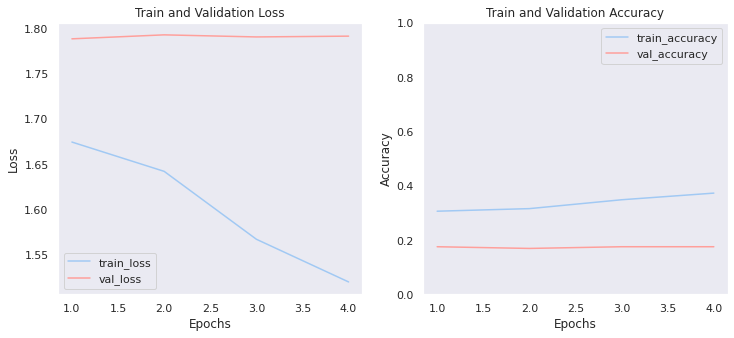

In [89]:
show_history(history)

- train accuracy도 안좋은걸 보니 모델 특징을 잘 못잡아내는것 같다.

In [90]:
# 모델 저장
model.save('shallow_resnet_model')

# history 저장
# Specify the directory path
directory_path = '/aiffel/aiffel/DLthon'

# Full file path
file_path = os.path.join(directory_path, 'shallow_resnet_train_history_dict.pkl')

# Assuming history.history is defined somewhere in your code
with open(file_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
# # history 불러오기 테스트
# history = pickle.load(open('/trainHistoryDict', "rb"))
# print(history)

INFO:tensorflow:Assets written to: shallow_resnet_model/assets


In [91]:
del model
del history

# ResNet18

In [92]:
# ResNet18 구현
'''
num_classes : 분류해야하는 클래스 수
'''
class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
            
        # conv1레이어는 직접 만들고
        self.conv_1 = SeparableConv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResidualBlock(64)
        self.res_1_2 = ResidualBlock(64)
        self.res_2_1 = ResidualBlock(128, down_sample=True) # 논문을 보면 여기에서 stride를 1, 1x1 convolution layer를 사용한다
        self.res_2_2 = ResidualBlock(128)
        self.res_3_1 = ResidualBlock(256, down_sample=True)
        self.res_3_2 = ResidualBlock(256)
        self.res_4_1 = ResidualBlock(512, down_sample=True)
        self.res_4_2 = ResidualBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, 
                          self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
            
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        
        return out

In [93]:
# 모델 생성
with tf.device('/GPU:0'):
    model = ResNet18(6)
    model.build(input_shape = (None,224,224,3))

    METRICS = ['accuracy']
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

In [94]:
# gpu로 모델학습

check_point_cb = ModelCheckpoint('resnet18', save_format='tf')

with tf.device('/GPU:0'):
    history = model.fit(
        train_batches,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_batches,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[check_point_cb, early_stopping_cb]
    )

Epoch 1/30
23/23 [==============================] - 9s 202ms/step - loss: 1.7017 - accuracy: 0.3492 - val_loss: 1.7949 - val_accuracy: 0.1375
INFO:tensorflow:Assets written to: resnet18/assets
Epoch 2/30
23/23 [==============================] - 4s 178ms/step - loss: 1.3240 - accuracy: 0.4742 - val_loss: 1.7955 - val_accuracy: 0.1562
INFO:tensorflow:Assets written to: resnet18/assets
Epoch 3/30
23/23 [==============================] - 4s 175ms/step - loss: 1.0831 - accuracy: 0.5815 - val_loss: 1.7970 - val_accuracy: 0.1562
INFO:tensorflow:Assets written to: resnet18/assets
Epoch 4/30
23/23 [==============================] - 4s 176ms/step - loss: 0.9340 - accuracy: 0.6617 - val_loss: 1.7990 - val_accuracy: 0.1562
INFO:tensorflow:Assets written to: resnet18/assets


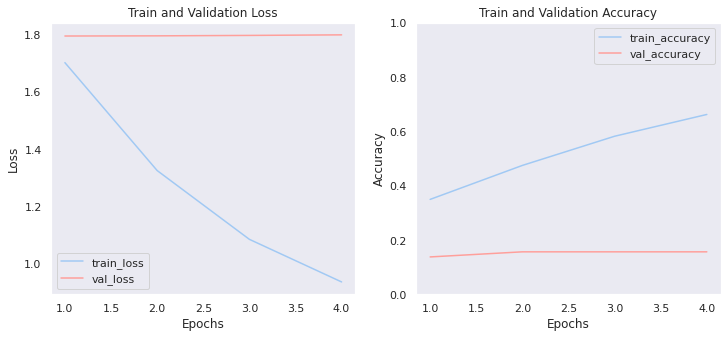

In [95]:
show_history(history)

In [96]:
# 모델 저장
model.save('resnet18_model_adam')

# history 저장
# Specify the directory path
directory_path = '/aiffel/aiffel/DLthon'

# Full file path
file_path = os.path.join(directory_path, 'resnet18_adam_train_history_dict.pkl')

# Assuming history.history is defined somewhere in your code
with open(file_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
# # history 불러오기 테스트
# history = pickle.load(open('/trainHistoryDict', "rb"))
# print(history)
    
del model
del history

INFO:tensorflow:Assets written to: resnet18_model_adam/assets


# optimization 수정
- RMSprop으로 변경 

In [97]:
# 모델 생성
with tf.device('/GPU:0'):
    model = ResNet18(6)
    model.build(input_shape = (None,224,224,3))

    METRICS = ['accuracy']
    
    model.compile(
        optimizer='rmsprop',
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

In [98]:
# gpu로 모델학습

check_point_cb = ModelCheckpoint('resnet18_rmsprop', save_format='tf')

with tf.device('/GPU:0'):
    history = model.fit(
        train_batches,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_batches,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[check_point_cb, early_stopping_cb]
    )

Epoch 1/30
23/23 [==============================] - 10s 196ms/step - loss: 2.0066 - accuracy: 0.2976 - val_loss: 1.7917 - val_accuracy: 0.1937
INFO:tensorflow:Assets written to: resnet18_rmsprop/assets
Epoch 2/30
23/23 [==============================] - 4s 176ms/step - loss: 1.4146 - accuracy: 0.4470 - val_loss: 1.7998 - val_accuracy: 0.1187
INFO:tensorflow:Assets written to: resnet18_rmsprop/assets
Epoch 3/30
23/23 [==============================] - 4s 179ms/step - loss: 1.2539 - accuracy: 0.5082 - val_loss: 1.7986 - val_accuracy: 0.1250
INFO:tensorflow:Assets written to: resnet18_rmsprop/assets
Epoch 4/30
23/23 [==============================] - 4s 182ms/step - loss: 1.0539 - accuracy: 0.5924 - val_loss: 1.8006 - val_accuracy: 0.1187
INFO:tensorflow:Assets written to: resnet18_rmsprop/assets


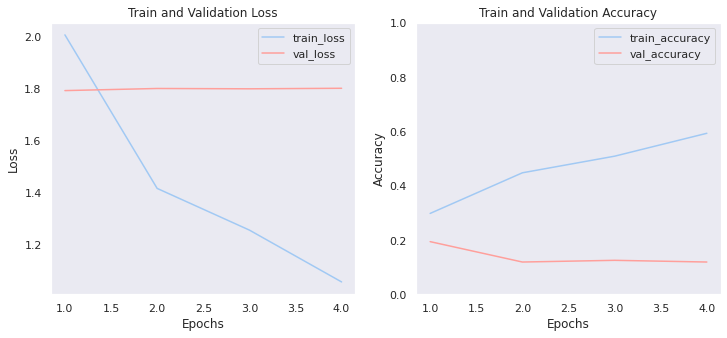

In [99]:
show_history(history)

- 형편없다...

In [100]:
# 모델 저장
model.save('resnet18_rmsprop_model')

# history 저장
# Specify the directory path
directory_path = '/aiffel/aiffel/DLthon'

# Full file path
file_path = os.path.join(directory_path, 'resnet18_rmsprop_train_history_dict.pkl')

# Assuming history.history is defined somewhere in your code
with open(file_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
# # history 불러오기 테스트
# history = pickle.load(open('/trainHistoryDict', "rb"))
# print(history)
    
del model
del history

INFO:tensorflow:Assets written to: resnet18_rmsprop_model/assets


# 데이터 전처리 2차 + Kfold
- 데이터셋 다시 세팅
- 이미지 픽셀 정규화
- kfold 진행

In [108]:
train_filenames[:3], val_filenames[:3], test_filenames[:3]

(['/aiffel/aiffel/jellyfish/Train_Test_Valid/Train/barrel_jellyfish/aug-56-20.jpg',
  '/aiffel/aiffel/jellyfish/Train_Test_Valid/Train/barrel_jellyfish/aug-41-01.jpeg',
  '/aiffel/aiffel/jellyfish/Train_Test_Valid/Train/blue_jellyfish/aug-41-56.jpg'],
 ['/aiffel/aiffel/jellyfish/Train_Test_Valid/Train/blue_jellyfish/aug-31-44.jpg',
  '/aiffel/aiffel/jellyfish/Train_Test_Valid/Train/lions_mane_jellyfish/aug-50-65.jpg',
  '/aiffel/aiffel/jellyfish/Train_Test_Valid/Train/barrel_jellyfish/aug-47-07.jpg'],
 ['/aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/69.jpg',
  '/aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/48.jpg',
  '/aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/34.jpg'])

In [130]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    image = (img/127.5) - 1 # 픽셀값 scale 수정 : -1~1 사이의 값
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # 이미지 사이즈를 IMAGE_SIZE로 수정 : 224x224
    return img

In [131]:
# 이미지 파일 경로로 이미지와 레이블 읽어오는 함수
def process_path(file_path):
    label = get_label(file_path) # 레이블 뽑기
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [132]:
# tf.data instance 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)


train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 이미지 리사이즈 결과, 레이블 확인
for image, label in train_ds.take(1): # 하나의 데이터만 가져온다
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
# 이미지 리사이즈 결과, 레이블 확인
for image, label in val_ds.take(1): # 하나의 데이터만 가져온다
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
# 이미지 리사이즈 결과, 레이블 확인
for image, label in test_ds.take(1): # 하나의 데이터만 가져온다
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  0
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  4


In [133]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 751
Validating images count: 188


In [134]:
train_ds

<ParallelMapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

# K-fold 검증사용 - basic cnn with regulation

In [136]:
# 데이터 증강을 위한 설정
data_augmentation = ImageDataGenerator(
    rotation_range=20,         # 회전 범위
    width_shift_range=0.2,     # 수평 이동 범위
    height_shift_range=0.2,    # 수직 이동 범위
    shear_range=0.2,           # 전단 변환 강도
    zoom_range=0.2,            # 확대/축소 범위
    horizontal_flip=True,      # 수평 뒤집기
    fill_mode='nearest',       # 증강된 이미지의 빈 공간을 채우는 방식
    brightness_range=[0.8,1.2] # 밝기 조정 범위
)

In [137]:
# convolution block
'''
- convolution 2번 
    - activation : relu
    - same padding
    - kernel size : 3x3
- batch normalization
- max pooling 
    - pool size : 2x2
'''
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, kernel_initializer='he_normal', kernel_regularizer=l2(0.01),
                                        activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, kernel_initializer='he_normal', kernel_regularizer=l2(0.01),
                                        activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [138]:
# dense block
'''
activation : relu
batch normalization
dropout
'''
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [139]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, kernel_initializer='he_normal', kernel_regularizer=l2(0.01), 
                               activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, kernel_initializer='he_normal', kernel_regularizer=l2(0.01),
                               activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.GlobalAveragePooling2D(),
        dense_block(32, 0.5),
        
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    return model

In [142]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = ['accuracy']
    
    model.compile(
        optimizer='rmsprop',
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

In [143]:
from sklearn.model_selection import StratifiedKFold

# StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 각 폴드에 대한 점수를 저장할 리스트
scores = []

# Assuming train_ds is a tuple (features, labels)
features = train_ds[0]
labels = train_ds[1]

# 교차 검증
fold_num = 1
for fold, (train_indices, val_indices) in enumerate(skf.split(features, labels)):
    train_data = (features[train_indices], labels[train_indices])
    val_data = (features[val_indices], labels[val_indices])

    # Apply data augmentation to the training set
    augmented_train_data = [(data_augmentation.random_transform(image), label) for image, label in zip(*train_data)]

    # Calculate the steps_per_epoch based on the size of the augmented_train_data
    steps_per_epoch = len(augmented_train_data) // BATCH_SIZE 

    # Train the model with augmented data
    model.fit(augmented_train_data, epochs=num_epochs, validation_data=val_data, steps_per_epoch=steps_per_epoch)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(*val_data)
    print(f"Validation accuracy for Fold {fold + 1}: {val_accuracy}")


TypeError: 'ParallelMapDataset' object is not subscriptable

In [145]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Assuming train_ds is a ParallelMapDataset with features and labels
train_data = np.array(list(train_ds.as_numpy_iterator()))

# Extract features and labels
features = train_data[:, 0]
labels = train_data[:, 1]

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_num = 1
with tf.device('/GPU:0'):
    for fold, (train_indices, val_indices) in enumerate(skf.split(features, labels)):
        train_data_fold = (features[train_indices], labels[train_indices])
        val_data_fold = (features[val_indices], labels[val_indices])

        # Apply data augmentation to the training set
        augmented_train_data = [(data_augmentation.random_transform(image), label) for image, label in zip(*train_data_fold)]

        # Calculate the steps_per_epoch based on the size of the augmented_train_data
        steps_per_epoch = len(augmented_train_data) // BATCH_SIZE  # Assuming BATCH_SIZE is defined

        # Train the model with augmented data
        model.fit(augmented_train_data, epochs=num_epochs, validation_data=val_data_fold, steps_per_epoch=steps_per_epoch)

        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(*val_data_fold)
        print(f"Validation accuracy for Fold {fold + 1}: {val_accuracy}")


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'unknown' instead.

In [146]:
features

array([array([[[0.16470589, 0.12156864, 0.86666673],
               [0.20392159, 0.16078432, 0.91372555],
               [0.15686275, 0.10980393, 0.8705883 ],
               ...,
               [0.        , 0.00784314, 0.0509804 ],
               [0.        , 0.00784314, 0.0509804 ],
               [0.        , 0.00784314, 0.04313726]],

              [[0.24705884, 0.20784315, 0.92549026],
               [0.29411766, 0.25490198, 0.9803922 ],
               [0.25882354, 0.21568629, 0.9607844 ],
               ...,
               [0.        , 0.00784314, 0.05490196],
               [0.        , 0.00784314, 0.04313726],
               [0.        , 0.00784314, 0.04313726]],

              [[0.36078432, 0.3254902 , 0.98823535],
               [0.42352945, 0.38431376, 1.        ],
               [0.3921569 , 0.35686275, 1.        ],
               ...,
               [0.        , 0.00392157, 0.05490196],
               [0.        , 0.00784314, 0.04313726],
               [0.        , 0.00784

In [147]:
labels

array([0, 0, 1, 5, 1, 1, 2, 2, 5, 2, 4, 1, 5, 1, 4, 0, 3, 5, 4, 5, 2, 2,
       2, 5, 0, 4, 3, 1, 2, 3, 4, 3, 2, 4, 3, 0, 5, 0, 4, 5, 0, 3, 4, 0,
       3, 3, 5, 4, 4, 0, 2, 5, 0, 1, 4, 3, 0, 5, 0, 5, 0, 5, 0, 0, 3, 4,
       5, 0, 2, 2, 5, 5, 2, 4, 3, 5, 5, 3, 0, 4, 5, 5, 3, 5, 2, 5, 3, 4,
       2, 2, 4, 3, 5, 1, 4, 4, 3, 0, 3, 3, 3, 0, 0, 3, 5, 5, 0, 3, 0, 1,
       5, 2, 3, 1, 2, 1, 1, 1, 1, 2, 4, 2, 1, 5, 0, 5, 5, 5, 0, 1, 4, 2,
       0, 5, 1, 2, 0, 1, 0, 3, 4, 4, 3, 1, 4, 3, 5, 2, 2, 0, 0, 4, 5, 2,
       5, 5, 0, 4, 2, 1, 2, 1, 4, 2, 4, 4, 2, 2, 2, 1, 4, 1, 3, 1, 3, 4,
       5, 0, 5, 4, 4, 2, 0, 2, 2, 1, 3, 3, 4, 5, 0, 5, 4, 3, 0, 2, 3, 1,
       4, 1, 1, 3, 1, 4, 5, 1, 3, 0, 2, 0, 2, 4, 0, 4, 2, 1, 5, 3, 4, 5,
       0, 5, 1, 5, 0, 0, 3, 5, 5, 0, 4, 1, 4, 5, 4, 1, 3, 1, 4, 0, 5, 3,
       1, 3, 4, 1, 3, 1, 2, 0, 3, 0, 1, 1, 1, 4, 2, 3, 1, 0, 1, 5, 0, 0,
       2, 4, 5, 5, 1, 5, 5, 5, 0, 2, 0, 3, 0, 0, 2, 4, 3, 5, 3, 1, 2, 1,
       3, 1, 0, 4, 0, 1, 5, 4, 4, 2, 0, 2, 2, 1, 4,

In [148]:
unique_labels = np.unique(labels)
print("Unique Labels:", unique_labels)

Unique Labels: [0 1 2 3 4 5]


In [149]:
# Assuming labels is your array of class labels
labels = np.array([0, 1, 2, 3, 4, 5])

# Specify the number of folds
num_folds = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Iterate over the folds
for fold, (train_indices, val_indices) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    train_data = train_ds[train_indices]
    val_data = train_ds[val_indices]
    
    # Apply data augmentation to the training set
    augmented_train_data = [(data_augmentation.random_transform(image), label) for image, label in train_data]

    # Calculate the steps_per_epoch based on the size of the augmented_train_data
    steps_per_epoch = len(augmented_train_data) // BATCH_SIZE  # Assuming BATCH_SIZE is defined

    # Train the model with augmented data
    model.fit(augmented_train_data, epochs=num_epochs, validation_data=val_data_fold, steps_per_epoch=steps_per_epoch)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(*val_data_fold)
    print(f"Validation accuracy for Fold {fold + 1}: {val_accuracy}")


ValueError: n_splits=5 cannot be greater than the number of members in each class.

In [150]:
# Count the occurrences of each class
class_counts = {label: np.sum(labels == label) for label in np.unique(labels)}

# Print the class counts
print("Class Counts:", class_counts)

Class Counts: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
